## Classifier Evaluation

Based on code example of "An Introduction to Machine Learning with Python" by A.C. Muller and S. Guido (O'Reilly). Adapted by M. Eirinaki.

Note: For this tutorial you will need to use the authors' helper functions included in the helper library mglearn. You will also need the helper function preamble.py. Download both from: https://github.com/amueller/introduction_to_ml_with_python

In [1]:
from preamble import *
%matplotlib inline

## Model evaluation and improvement

So far we have been using the train_test_split function to split our dataset in training and test set (default values 75%-25%). 

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

iris = load_iris()
# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
# Instantiate a model and fit it to the training set
tree = DecisionTreeClassifier().fit(X_train, y_train)
# evaluate the model on the test set using accuracy
print("Test set score: {:.2f}".format(tree.score(X_test, y_test)))

Test set score: 0.97


### Cross-validation

K-fold cross-validation (where k is a user-specified number, usually set to 5 or 10) is a more robust way to assess generalization performance (or perform hyperparameter tuning as we will see later). 

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2790: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
  ret = ax.barh(*args, **kwargs)


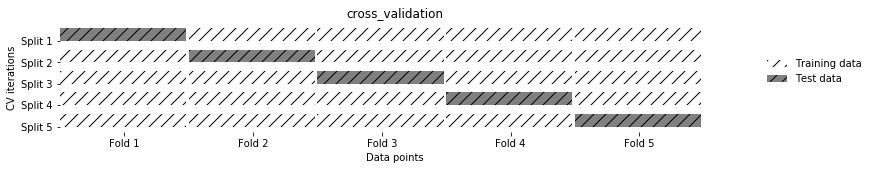

In [15]:
#visualization of 5-fold cross-validation
mglearn.plots.plot_cross_validation()

#### Cross-validation in scikit-learn

One way to perform cross-validation is by calling the cross_val_score function
(note that there are more than one ways to do it).

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
tree = DecisionTreeClassifier()

scores = cross_val_score(tree, iris.data, iris.target, cv=5) 
#cv: determines the strategy to be used. If integer, it represents number of folds 
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.967 0.967 0.9   1.    1.   ]


In [31]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.97


Note that cross-validation generates an average score (in this case accuracy), but will not output which model is the best. 

For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used (i.e., the folds are stratified). In all other cases, KFold is used.

### Grid Search

One of the main steps when fitting a model is hyperparameter tuning. For algorithms that have one or more parameters to set, we need to evaluate which combination works best for our dataset. 

This inherently creates a "grid" of options. 

For example, consider the case of using Random Forest as the classifier. We need to define parameters such as number of estimators (trees) and maximum depth.

We could evaluate those via a for-loop, iterating through all the possible combinations and keeping the parameters that yield the best score.

#### Simple Grid-Search

In [38]:
# naive grid search implementation
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for n_estimators in [1, 3, 5, 10]:
    for max_depth in [1, 2, 3]:
        # for each combination of parameters
        # train a Random Forest
        rf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = 10)
        rf.fit(X_train, y_train)
        # evaluate the Random Forest on the test set 
        score = rf.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth}
            
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'n_estimators': 3, 'max_depth': 2}


### The danger of overfitting the parameters, and the validation set

The reported accuracy, while looks great, won't necessarily carry over to new (unseen) data. This is because we used the test data to adjust the parameters. Any decisions made based on the test set accuracy "leak" information from the test set into the model. If we use the same model to adjust the parameters AND decide on the best model, we essentially overfit it. 

Therefore, it is good practice to use a "validation" set, particularly used to adjust the parameters, and keep a separate set ("test" set) which is only used for the final evaluation. 

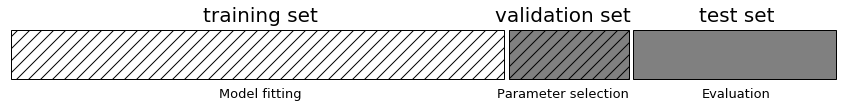

In [19]:
mglearn.plots.plot_threefold_split()

We can first split our data to "training+validation" and "test" sets, as previously. 
Then, the "training+validation" set can be spit for hyperparameter tuning, either using the same approach (train_test_split) or using n-fold cross-validation. 

We then build the model with the combined training + validation set (with optimal parameters) and evaluate against the test set. 

#### Variation 1: Manual grid search with train_test_split for both subsets

In [39]:
#from sklearn.ensemble import RandomForestClassifier
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

# split train+validation set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for n_estimators in [1, 3, 5, 10]:
    for max_depth in [1, 2, 3]:
        # for each combination of parameters
        # train a Random Forest
        rf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = 10)
        rf.fit(X_train, y_train)
        # evaluate the Random Forest on the test set 
        score = rf.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth}
            
            
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
rf = RandomForestClassifier(**best_parameters)
rf.fit(X_trainval, y_trainval)
test_score = rf.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.97
Best parameters:  {'n_estimators': 3, 'max_depth': 2}
Test set score with best parameters: 0.92


Notice how the new accuracy is lower than the previous one.

#### Variation 2: Manual Grid-search with cross-validation

In [41]:
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

best_score = 0

for n_estimators in [1, 3, 5, 10]:
    for max_depth in [1, 2, 3]:
        # for each combination of parameters
        # train a Random Forest
        rf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = 10)
        # perform cross-validation
        scores = cross_val_score(rf, X_trainval, y_trainval, cv=5) #notice that we use the original training+validation set here
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth}
            
            
# rebuild a model on the combined training and validation set
rf = RandomForestClassifier(**best_parameters)
rf.fit(X_trainval, y_trainval)

test_score = rf.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.95
Best parameters:  {'n_estimators': 1, 'max_depth': 2}
Test set score with best parameters: 0.97


Notice here how best score on validation set is lower (because we are reporting average over n folds)

#### Variation 3: Using the GridSearchCV class to perform grid search

Instead of the nested for loops, you can use the GridSearchCV class, which implements grid search with cross-validation in the form of an estimator. 


In [48]:
from sklearn.model_selection import GridSearchCV

#Set the parameters you want to evaluate 
param_grid = {'n_estimators':  [1, 3, 5, 10],
              'max_depth': [1, 2, 3]}
#create the GridSearch object for the Random Forest classifier passing the parameters
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)


# split data into train set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
#fit data to the model -- cross validation will be performed during grid search
grid_search.fit(X_trainval, y_train)


print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
#you can also print the best estimator:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'max_depth': 3, 'n_estimators': 3}
Best cross-validation score: 0.96
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Test set score: 0.95


### Visualization of the entire process

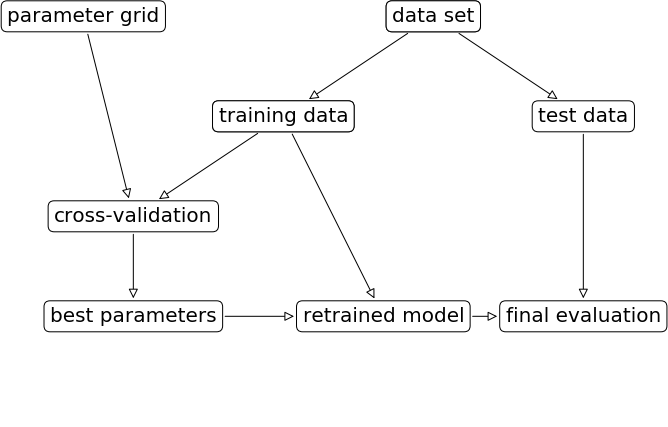

In [43]:
mglearn.plots.plot_grid_search_overview()